In [1]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [12]:
!pip install pettingzoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 10.7 MB/s eta 0:00:00


In [2]:
!pip install 'shimmy>=2.0'

In [3]:
!pip install modin[ray]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.2 MB/s eta 0:00:00


In [4]:
!pip install supersuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 7.2 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

In [6]:
import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from typing import Dict
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, SAC
from gym.wrappers import FlattenObservation
from typing import Tuple, Dict, Optional, Any
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.utils import get_linear_fn
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [7]:
def optimal_linear_kyle(sigma_u, mean_v, sigma_v):
    beta = math.sqrt(sigma_u ** 2 / sigma_v)  # Insider's coefficient
    lambda_ = 0.5 * math.sqrt(sigma_v / (sigma_u ** 2))  # MM's coefficient
    return beta, lambda_

def optimal_insider_x(v, sigma_u, mean_v, sigma_v):
    beta, _ = optimal_linear_kyle(sigma_u, mean_v, sigma_v)

    return beta * (v - mean_v)

def set_linear_price(y, sigma_v, sigma_u, mean_v):
    beta, lambda_ = optimal_linear_kyle(sigma_u, mean_v, sigma_v)
    return mean_v + lambda_ * y

In [ ]:
class KyleModelEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, T=1, gamma=0.9):
        super(KyleModelEnv, self).__init__()

        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.T = T
        self.gamma = gamma
        self.actual_actions = []

        # Define action and observation spaces
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        self.observation_space = spaces.Dict({
            'v': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        })

        self.reset()

    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)

        self.v = np.random.normal(self.p0, self.sigma_v)  # True asset value
        self.p = self.p0
        self.t = 0

        obs = self._get_insider_obs()
        info = {}
        return obs, info  # Gymnasium requires (obs, info)

    def _get_insider_obs(self):
        return {
            'v': np.array([self.v], dtype=np.float32)
        }

    def step(self, action):
        """Execute one step"""
        if self.t >= self.T:
            raise ValueError("Episode has already ended")

        scaled_action = action * 10
        self.actual_actions.append(scaled_action[0])

        x = scaled_action[0]
        u = np.random.normal(0, self.sigma_u)
        y = x + u
        lambda_kyle = 0.5 * math.sqrt(self.sigma_v / (self.sigma_u ** 2))
        p_new = self.p + lambda_kyle * y

        insider_profit = (self.v - p_new) * x

        # Update state
        self.p = p_new
        self.t += 1

        terminated = (self.t >= self.T)  # natural end
        truncated = False  # No time/truncation logic here

        obs = self._get_insider_obs()
        info = {}

        return obs, insider_profit, terminated, truncated, info



# Example usage with Gym interface
print("Testing Kyle model with Gym interface")

env_insider = KyleModelEnv()

# Initialize the model

clip_range_schedule = get_linear_fn(start=0.3, end=0.2, end_fraction=0.9)




policy_kwargs = dict(
    net_arch=[64]
)

model_insider = PPO(
    "MultiInputPolicy",
    env_insider,
    verbose = 1,
    learning_rate = 0.001,
    clip_range = clip_range_schedule,
    policy_kwargs=policy_kwargs,
    ent_coef = 0.03

)

model_insider.learn(total_timesteps=55_000)
model_insider.save("ppo_mm")

# Test trained agent
obs = env_insider.reset()
obs = env_insider.reset()

Testing Kyle model with Gym interface
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -24.7    |
| time/              |          |
|    fps             | 1478     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | -20.7      |
| time/                   |            |
|    fps                  | 1006       |
|    iterations           | 2          |
|    time_elapsed         | 4          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.06918069 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.296      |
|    entropy_loss         | -1.29      |
|    explained_variance   | 0.000403   |
|    learning_rate        | 0.001      |
|   

Streaming output truncated to the last 5000 lines.
actual_x 1.2688442211055277
Insider: 0.9617810249328613
actual_x 1.2688442211055277
Insider: 1.5897157192230225
actual_x 1.2688442211055277
Insider: 1.4307887554168701
actual_x 1.2688442211055277
Insider: 1.5638549327850342
actual_x 1.2688442211055277
Insider: 0.9624161720275879
actual_x 1.2688442211055277
Insider: 1.188455581665039
actual_x 1.2688442211055277
Insider: 1.2817645072937012
actual_x 1.2688442211055277
Insider: 1.2660728693008423
actual_x 1.2688442211055277
Insider: 1.5664256811141968
actual_x 1.2688442211055277
Insider: 0.9415864944458008
actual_x 1.2688442211055277
Insider: 1.650998830795288
actual_x 1.2688442211055277
Insider: 1.7354047298431396
actual_x 1.2688442211055277
Insider: 0.8300058841705322
actual_x 1.2688442211055277
Insider: 1.7689366340637207
actual_x 1.2688442211055277
Insider: 1.540083646774292
actual_x 1.2688442211055277
Insider: 1.474100947380066
actual_x 1.2688442211055277
Insider: 1.455077052116394
ac

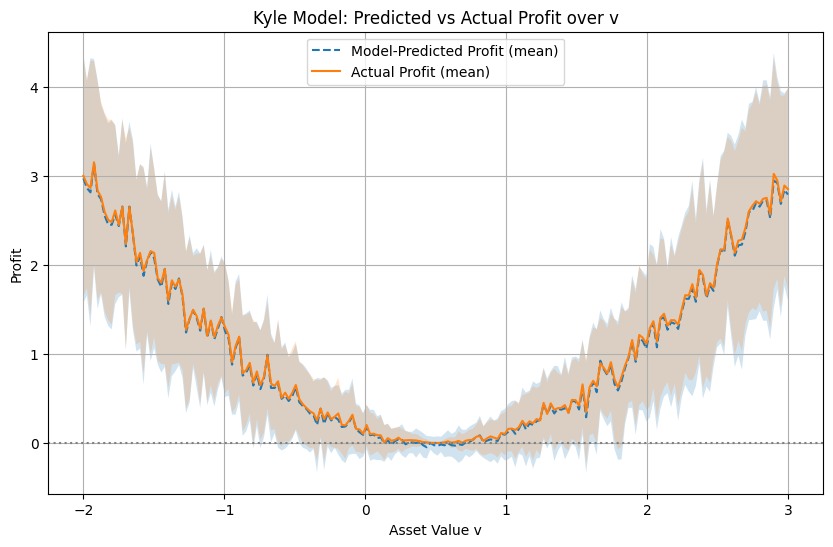

In [ ]:
def evaluate_profits(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_profits = np.zeros((num_trials, num_points))
    actual_profits = np.zeros((num_trials, num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        obs['v'][0] = v
        env.v = v

        for j in range(num_trials):

            #  and draw fixed v and u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)


            action, _ = model.predict(obs)
            # 1. Scale PPO's normalized action to market order size

            x = action[0] * 10  # scale to actual action

            y = x + u
            p_new = env.p0 + lambda_kyle * y

            # Predicted profit using known v and expected price impact
            predicted_profit = (v - p_new) * x

            # Actual profit using random u

            actual_x = beta_kyle * (v - env.p0)
            y = actual_x + u
            p_new = env.p0 + lambda_kyle * y
            actual_profit = (v - p_new) * actual_x

            predicted_profits[j][i] = predicted_profit
            actual_profits[j][i] = actual_profit
            print(f"actual_x {actual_x}")
            print(f"Insider: {x}")


    return predicted_profits, actual_profits


def plot_profits(predicted_profits, actual_profits, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -2
end_point = 3
num_points = 200
num_trials = 100
predicted, actual = evaluate_profits(env_insider, start_point, end_point, model_insider, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




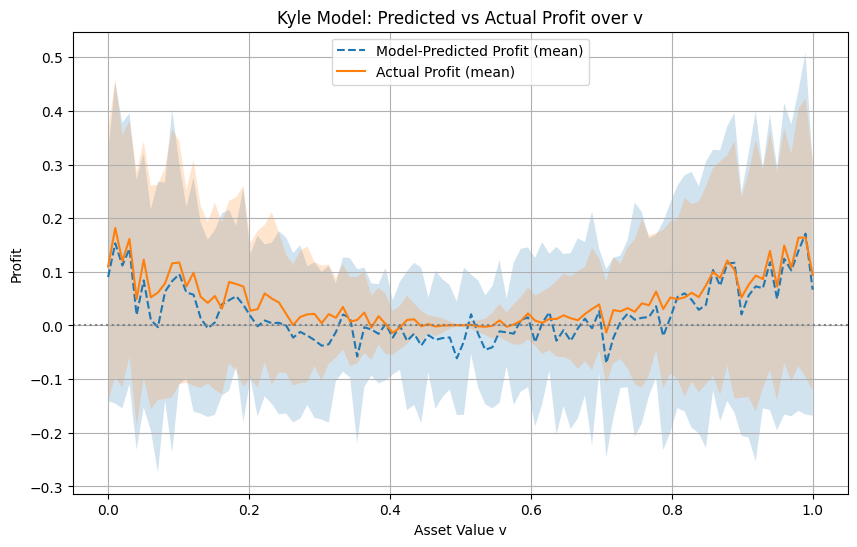

In [ ]:
start_point = 0
end_point = 1
num_points = 100
num_trials = 50
predicted, actual = evaluate_profits(env_insider, start_point, end_point, model_insider, num_points = 100)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)


In [ ]:

class KyleModelEnvMM(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, T=1, gamma=0.9):
        super(KyleModelEnvMM, self).__init__()

        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.T = T
        self.gamma = gamma
        self.actual_actions = []

        self.beta_kyle, _ = optimal_linear_kyle(self.sigma_u, self.p0, self.sigma_v)

        # Define action space (Market Maker's price guess)
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        # Observation space for the market maker
        self.observation_space = spaces.Dict({
            'y': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'p0': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'sigma_v': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'sigma_u': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        })

    def reset(self, *, seed=None, options=None):
        """Reset the environment to initial state"""
        super().reset(seed=seed)

        # True asset value is drawn from N(p0, sigma_v^2)
        self.v = np.random.normal(self.p0, self.sigma_v)

        # Initialize state variables
        self.p = self.p0
        self.t = 0

        # Generate initial observation
        self.x = self.beta_kyle * (self.v - self.p0)
        u = np.random.normal(0, self.sigma_u)
        self.y = self.x + u

        obs = self._get_mm_obs()
        info = {}
        return obs, info  # Gymnasium requires (obs, info)

    def _get_mm_obs(self) -> Dict[str, np.ndarray]:
        return {
            'y': np.array([self.y], dtype=np.float32),
            'p0': np.array([self.p], dtype=np.float32),
            'sigma_v': np.array([self.sigma_v], dtype=np.float32),
            'sigma_u': np.array([self.sigma_u], dtype=np.float32)
        }

    def step(self, action):
        """Execute one step of the environment"""
        if self.t >= self.T:
            raise ValueError("Episode has already ended")

        # Scale PPO's normalized action to market price guess
        scaled_action = action[0] * 10
        self.actual_actions.append(scaled_action)

        # Market maker's loss function (negative MSE against true value)
        mm_loss = -((scaled_action - self.v) ** 2)

        # Update timestep
        self.t += 1

        terminated = (self.t >= self.T)  # natural termination
        truncated = False  # no time truncation here

        obs = self._get_mm_obs()
        info = {}

        return obs, mm_loss, terminated, truncated, info







# Example usage with Gym interface
print("Testing Kyle model with Gym interface")

env_mm = KyleModelEnvMM()

# Initialize the model

clip_range_schedule = get_linear_fn(start=0.3, end=0.2, end_fraction=0.9)




policy_kwargs = dict(
    net_arch=[64,64]
)

model_mm = PPO(
    "MultiInputPolicy",
    env_mm,
    verbose = 1,
    learning_rate = 0.001,
    clip_range = clip_range_schedule,
    policy_kwargs=policy_kwargs,
    ent_coef = 0.03

)

model_mm.learn(total_timesteps=75_000)
model_mm.save("ppo_mm")

# Test trained agent
obs = env_mm.reset()

Testing Kyle model with Gym interface
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    fps             | 1116     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | -47         |
| time/                   |             |
|    fps                  | 800         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.086519174 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.297       |
|    entropy_loss         | -1.29       |
|    explained_variance   | -0.000592   |
|    learning_rate        | 0.

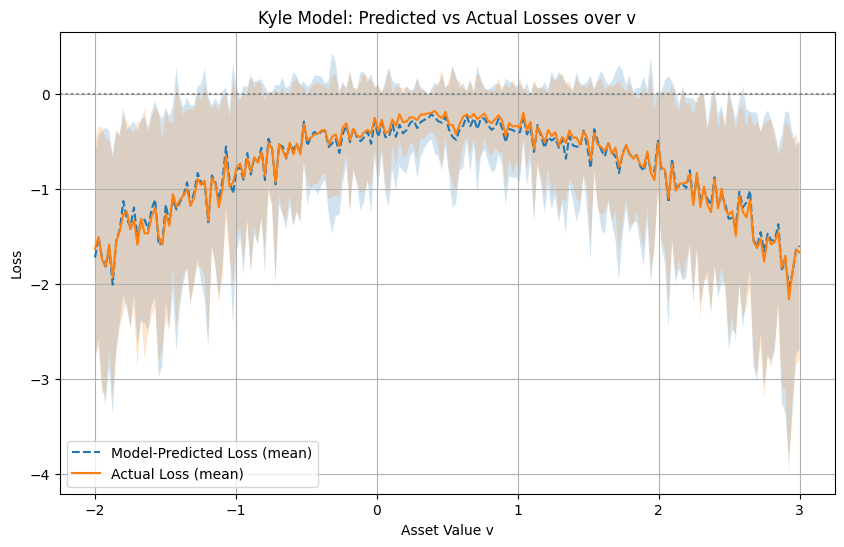

In [ ]:
def evaluate_losses(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_losses = np.zeros((num_trials, num_points))
    actual_losses = np.zeros((num_trials, num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        env.v = v

        for j in range(num_trials):

            #  and sample u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)
            x = beta_kyle * (v - env.p0)


            y = x + u
            obs['y'] = np.array([y], dtype=np.float32)

            # Scale PPO's normalized action to market order size
            action, _ = model.predict(obs)
            scaled_action = action[0] * 10  # scale to actual action




            kyle_price = env.p0 + lambda_kyle * y

            predicted_loss = - ((scaled_action - v) ** 2)
            actual_loss = - ((v - kyle_price) ** 2)

            predicted_losses[j][i] = predicted_loss
            actual_losses[j][i] = actual_loss
            if actual_loss > 20:
                print(f"beta kyle : {beta_kyle}")
                print(f"lambda kyle : {lambda_kyle}")
                print(f"predicted loss : {predicted_loss}")
                print(f"actual loss : {actual_loss}")
                print(f"scaled action : {scaled_action}")
                print(f"kyle price : {kyle_price}")
                print(f"x : {x}")
                print(f"y : {y}")
                print(f"u : {u}")
                print(f"v : {v}")


    return predicted_losses, actual_losses


def plot_losses(predicted_losses, actual_losses, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Loss (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Loss (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Loss")
    plt.title("Kyle Model: Predicted vs Actual Losses over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -2
end_point = 3
num_points = 200
num_trials = 100
predicted, actual = evaluate_losses(env_mm, start_point, end_point, model_mm, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_losses(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




In [13]:
from pettingzoo.utils import AECEnv, agent_selector, aec_to_parallel
from ray.rllib.env import PettingZooEnv
from ray import tune
import ray
import numpy as np
from gymnasium import spaces
from pettingzoo.utils import ParallelEnv
from ray.rllib.env import PettingZooEnv
from ray import tune
import ray

2025-08-14 13:41:19,050	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [14]:
import functools
import glob
import os
import time

import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy, MlpPolicy

In [15]:
import gymnasium as gym

from ray.rllib.env.multi_agent_env import MultiAgentEnv

In [16]:
class KyleOnePeriodAEC(ParallelEnv):
    metadata = {
        "render_modes": ["human"],
        "name": "KyleOnePeriodParallel",
    }

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma = 0.9, T = 1):
        super().__init__()
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.timestep = 0
        self.gamma = gamma
        self.T = T

        self.possible_agents = ["insider", "market_maker"]
        self.render_mode = None  # add this line

        self.action_spaces = {
            "insider": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32),
            "market_maker": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        }

        self.observation_spaces = {
            "insider": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
            "market_maker": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
        }




    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {a: 0 for a in self.agents}

        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}

        self.infos = {a: {} for a in self.agents}
        self.timestep = 0

        # Sample true value
        self.v = np.random.normal(self.p0, self.sigma_v)
        self.u = np.random.normal(0, self.sigma_u)
        self.p = 0
        self.y = 0

        observations = {}
        observations["insider"] = self.observe_insider()
        observations["market_maker"] = self.observe_market_maker()

        # Get dummy infos. Necessary for proper parallel_to_aec conversion
        infos = {a: {} for a in self.agents}


        return observations, infos

    def observe(self, agent):
        if agent == "insider":
            return self.observe_insider()
        elif agent == "market_maker":
            return self.observe_market_maker()

    def observe_insider(self):
        return np.array([self.v, self.p0, self.sigma_v**2, self.sigma_u**2], dtype=np.float32)

    def observe_market_maker(self):
        return np.array([self.p0, self.sigma_v**2, self.sigma_u**2, self.y], dtype=np.float32)

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self.action_spaces[agent]


    def step(self, actions):
        # Default rewards
        rewards = {a: 0 for a in self.agents}

        # Only update actions for agents that actually have an action
        insider_action = actions["insider"][0] * 10
        market_maker_action = actions["market_maker"][0] * 10


        self.y = insider_action + self.u
        insider_profit = (self.v - market_maker_action) * insider_action
        market_maker_loss = -((market_maker_action - self.v) ** 2)

        if "insider" in self.agents:
            rewards["insider"] = insider_profit
        if "market_maker" in self.agents:
            rewards["market_maker"] = market_maker_loss

        self.rewards = rewards



        # Observations
        observations = {}
        if "insider" in self.agents:
            observations["insider"] = self.observe_insider()
        if "market_maker" in self.agents:
            observations["market_maker"] = self.observe_market_maker()

        infos = {a: {} for a in self.agents}

        # Increase timestep
        self.timestep += 1
        if self.timestep >= self.T:
            terminations = {a: True for a in ["insider", "market_maker"]}
            truncations = {a: True for a in ["insider", "market_maker"]}
        else:
            terminations = {a: False for a in ["insider", "market_maker"]}
            truncations = {a: False for a in ["insider", "market_maker"]}

        return observations, rewards, terminations, truncations, infos





        # Get observations
        observations = {}
        observations["insider"] = self.observe_insider()
        observations["market_maker"] = self.observe_market_maker()

        # Get dummy infos (not used in this example)
        infos = {a: {} for a in self.agents}


        return observations, rewards, terminations, truncations, infos

    def render(self):
        print(f"Step: {self.timestep}")
        print(f"True value v: {self.v:.2f}")
        print(f"Order flow y: {self.y:.2f}")
        insider_reward = self.rewards["insider"]
        print(f"Agents' rewards: {insider_reward}")




In [ ]:
from __future__ import annotations
import glob
import os
import time

import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy, MlpPolicy


def train_multi_agent(env_fn, steps: int = 10_000, loops: int = 50, seed: int | None = 0, **env_kwargs):
    env = env_fn(**env_kwargs)
    env = ss.black_death_v3(env)  # Handle agent death
    env.reset(seed=seed)

    print(f"Starting training on {env.metadata['name']} with {len(env.possible_agents)} agents.")

    env_vec = ss.pettingzoo_env_to_vec_env_v1(env)
    env_vec = ss.concat_vec_envs_v1(env_vec, 8, num_cpus=0, base_class="stable_baselines3")

    # Create a PPO model for each agent
    models = {}
    for agent in env.possible_agents:
        models[agent] = PPO(MlpPolicy, env_vec, verbose=3, batch_size=256)

    # Train models in interchangeable loops
    for loop in range(loops):
        print(f"=== Training loop {loop+1}/{loops} ===")
        for agent in env.possible_agents:
            print(f"Training model for {agent}")
            models[agent].learn(total_timesteps=steps)

    # Save all models after training
    for agent, model in models.items():
        model_path = f"{env.metadata['name']}_{agent}_{time.strftime('%Y%m%d-%H%M%S')}"
        model.save(model_path)
        print(f"Saved model for {agent} -> {model_path}")

    env.close()
    return models




env_fn = KyleOnePeriodAEC
env_kwargs = dict(sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma = 0.9, T = 1)

# Train a separate model for each agent
models = train_multi_agent(env_fn, steps=50_000, seed=0, **env_kwargs)

Starting training on KyleOnePeriodParallel with 2 agents.
Using cpu device
Using cpu device
=== Training loop 1/50 ===
Training model for insider
------------------------------
| time/              |       |
|    fps             | 7319  |
|    iterations      | 1     |
|    time_elapsed    | 4     |
|    total_timesteps | 32768 |
------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 4011       |
|    iterations           | 2          |
|    time_elapsed         | 16         |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.04362922 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.3       |
|    explained_variance   | 0.00106    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.32e+03   |
|    n_updates            | 10         |
|    policy_gradient_l

In [17]:
from stable_baselines3 import PPO

insider_model = PPO.load("KyleOnePeriodParallel_insider_20250814-015141")
market_maker_model = PPO.load("KyleOnePeriodParallel_market_maker_20250814-001537")

models = {
    "insider": insider_model,
    "market_maker": market_maker_model
}


In [18]:
env = KyleOnePeriodAEC(sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma=0.9, T=1)
observations, infos = env.reset()

In [22]:
actions = {}
beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)

print(f"v value is {env.v}")
print(f"x_optimal {beta_kyle*(env.v-env.p0)}")


for agent, model in models.items():
    obs = observations[agent]
    action, _states = model.predict(obs, deterministic=True)  # or False if you want stochastic
    actions[agent] = action



    print(f"Agent: {agent}, Action: {action}")



v value is 1.1813457885867087
x_optimal 0.6813457885867087
Agent: insider, Action: [0.90708625]
Agent: market_maker, Action: [0.07668986]


Streaming output truncated to the last 5000 lines.
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36068832874298096
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3718290328979492
v value is 0.7638190954773871
Agent: market_maker, Action: 0.33802521228790283
v value is 0.7638190954773871
Agent: market_maker, Action: 0.38235533237457275
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36364632844924927
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3876854479312897
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3699757754802704
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3655184805393219
v value is 0.7638190954773871
Agent: market_maker, Action: 0.37164291739463806
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36300525069236755
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36692655086517334
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36268797516822815
v val

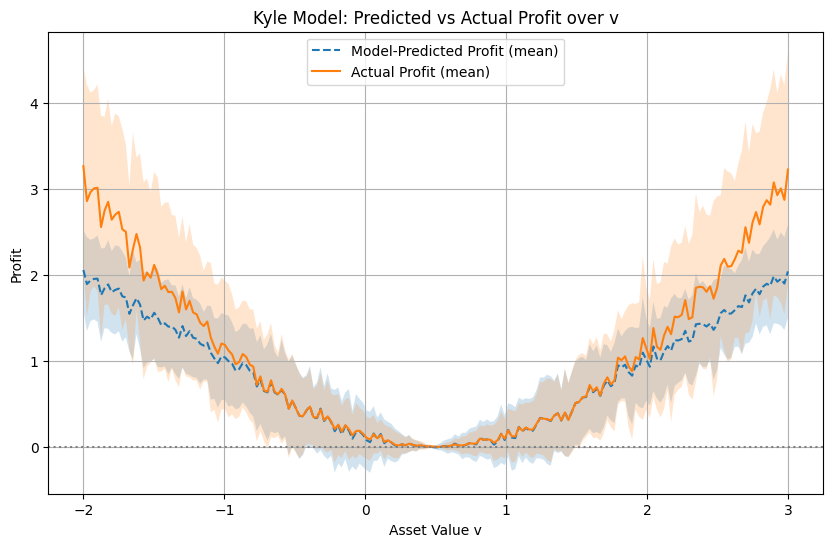

In [26]:
def evaluate_profits(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_profits = np.zeros((num_trials, num_points))
    actual_profits = np.zeros((num_trials, num_points))
    agent1 = "insider"


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        obs = observations[agent]
        obs[0] = v
        env.v = v

        for j in range(num_trials):

            #  and draw fixed v and u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)


            action, _ = model.predict(obs)
            # 1. Scale PPO's normalized action to market order size
            action_unscaled = float(action[0])


            x = action_unscaled  # scale to actual action
            if v > -1 and v < 2:
                print(f"v value is {env.v}")
                print(f"Agent: {agent}, Action: {x}")
            y = x + u
            p_new = env.p0 + lambda_kyle * y

            # Predicted profit using known v and expected price impact
            predicted_profit = (v - p_new) * x

            # Actual profit using random u

            actual_x = beta_kyle * (v - env.p0)
            y = actual_x + u
            p_new = env.p0 + lambda_kyle * y
            actual_profit = (v - p_new) * actual_x

            predicted_profits[j][i] = predicted_profit
            actual_profits[j][i] = actual_profit


    return predicted_profits, actual_profits


def plot_profits(predicted_profits, actual_profits, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -2
end_point = 3
num_points = 200
num_trials = 100
predicted, actual = evaluate_profits(env, start_point, end_point, insider_model, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




In [ ]:
start_point = -1
end_point = 2
num_points = 200
num_trials = 100
predicted, actual = evaluate_profits(env, start_point, end_point, insider_model, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)



In [ ]:
start_point = -0.5
end_point = 1.5
num_points = 200
num_trials = 100
predicted, actual = evaluate_profits(env, start_point, end_point, insider_model, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)


In [ ]:
import numpy as np
import gymnasium as gym
from ray.rllib.env.multi_agent_env import MultiAgentEnv

class KyleOnePeriodRLlib(MultiAgentEnv):
    """Kyle's model environment adapted for RLlib's MultiAgentEnv API."""

    def __init__(self, config=None):
        super().__init__()

        # Extract parameters from config or use defaults
        config = config or {}
        self.sigma_v = config.get("sigma_v", 1.0)
        self.sigma_u = config.get("sigma_u", 1.0)
        self.p0 = config.get("p0", 0.5)
        self.gamma = config.get("gamma", 0.9)
        self.T = config.get("T", 1)

        self.timestep = 0

        # Define possible agents
        self.possible_agents = ["insider", "market_maker"]
        self.agents = self.possible_agents[:]

        # Define observation and action spaces
        self.observation_spaces = {
            "insider": gym.spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
            "market_maker": gym.spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
        }

        self.action_spaces = {
            "insider": gym.spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
            "market_maker": gym.spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
        }

        # Initialize state variables
        self.v = 0
        self.u = 0
        self.p = 0
        self.y = 0

    def reset(self, *, seed=None, options=None):
        """Resets the environment and returns initial observations."""
        super().reset(seed=seed)

        self.timestep = 0
        self.agents = self.possible_agents[:]

        # Sample true value and noise
        self.v = self.np_random.normal(self.p0, self.sigma_v)
        self.u = self.np_random.normal(0, self.sigma_u)
        self.p = 0
        self.y = 0

        # Return observations for all agents
        observations = {
            "insider": self.observe_insider(),
            "market_maker": self.observe_market_maker(),
        }

        return observations, {}

    def step(self, action_dict):
        """Executes one environment step for all agents."""
        # Execute actions
        insider_action = action_dict["insider"][0]
        market_maker_action = action_dict["market_maker"][0]

        # Update environment state
        self.y = insider_action + self.u
        insider_profit = (self.v - market_maker_action) * insider_action
        market_maker_loss = -((market_maker_action - self.v) ** 2)

        # Calculate rewards
        rewards = {
            "insider": insider_profit,
            "market_maker": market_maker_loss,
        }

        # Update timestep and check termination
        self.timestep += 1
        terminations = {a: False for a in self.agents}
        truncations = {a: False for a in self.agents}

        if self.timestep >= self.T:
            terminations = {a: True for a in self.agents}
            self.agents = []

        # Get new observations
        observations = {
            "insider": self.observe_insider(),
            "market_maker": self.observe_market_maker(),
        }

        # Dummy infos
        infos = {a: {} for a in self.agents}

        return observations, rewards, terminations, truncations, infos

    def observe_insider(self):
        return np.array([self.v, self.p0, self.sigma_v**2, self.sigma_u**2], dtype=np.float32)

    def observe_market_maker(self):
        return np.array([self.p0, self.sigma_v**2, self.sigma_u**2, self.y], dtype=np.float32)


    def get_observation_space(self, agent_id):
        return self.observation_spaces[agent_id]

    def render(self):
        """Renders the current state of the environment."""
        print(f"Step: {self.timestep}")
        print(f"True value v: {self.v:.2f}")
        print(f"Order flow y: {self.y:.2f}")
        if hasattr(self, "rewards"):
            print(f"Agents' rewards: {self.rewards}")